# Generator optimisation problem

**Group details:**  
**Name:** Gautham Vadakkekara Suresh 
**Student ID:** 20231652 

**Name:** Prakhar Gurawa
**Student ID:** 20231064

**Task details:**
Given a set of 10 generators ( Hydro-electricity, Solid fuel, Gas and Solar) we need to opearate the generators at minimum cost considering different constraints.
The constraints are as follows:
1. The energy produced by each generator per hour should be in range of lower and upper bounds.
2. The energy produced by solid fuel per hour is constant.
3. The total energy produced per hour should match with demand of city.
4. The efficieny of solar energy varies from hour to hour.

    





## Install requirements

In [ ]:
# Uncomment below line if you need to install the requirements
#! pip install pandas numpy matplotlib seaborn ortools

## Import modules

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ortools.linear_solver import pywraplp
%matplotlib inline

## Read datasets

Read details about generators to dataframe

In [ ]:
gen_info_df = pd.read_csv('generator_info.csv', index_col='name')

In [ ]:
gen_info_df.head()

,type,lower_bound (MW),upper_bound (MW),cost/MW,CO2/MW
name,,,,,
A,hydro,10,100,1.4,0.024
B,hydro,10,80,1.4,0.024
C,hydro,10,60,1.4,0.024
D,hydro,1,10,1.4,0.024
E,solid,100,900,4.4,0.820


In [ ]:
# Rename column names for easy reference
gen_info_df.rename(columns = {'lower_bound (MW)' : 'lb', 'upper_bound (MW)': 'ub', 'cost/MW': 'cost/mw', 'CO2/MW': 'co2/mw'}, inplace=True)

In [ ]:
gen_info_df

,type,lb,ub,cost/mw,co2/mw
name,,,,,
A,hydro,10,100,1.4,0.024
B,hydro,10,80,1.4,0.024
C,hydro,10,60,1.4,0.024
D,hydro,1,10,1.4,0.024
E,solid,100,900,4.4,0.820
F,solid,100,600,4.4,0.820
G,solid,10,100,4.4,0.820
H,gas,100,400,9.1,0.490
I,solar,0,70,6.6,0.000


Read energy/electricity demand information to dataframe and plot hourly demand using a graph.

In [ ]:
demand_df = pd.read_csv('demand.csv', header=None, names=['mw'])
demand_df.head()

,mw
0,1461
1,1446
2,1446
3,1438
4,1425


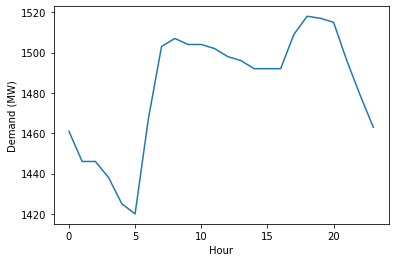

In [ ]:
# Lets plot the hourly demand
plt.plot(demand_df['mw'])
plt.xlabel('Hour')
plt.ylabel('Demand (MW)');

Read solar generator efficiency information to dataframe

In [ ]:
solar_curve_df = pd.read_csv('solar_curve.csv', header=None, names=['limit'])
solar_curve_df.head() 

,limit
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


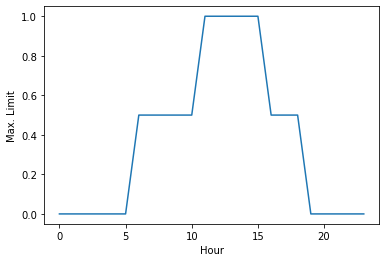

In [ ]:
# Lets plot hourly solar limit
plt.plot(solar_curve_df['limit'])
plt.xlabel('Hour')
plt.ylabel('Max. Limit');

## Declare the solver

Since we want to do linear programming for this task, we are going to use GLOP linear programming module.

In [ ]:
solver = pywraplp.Solver('Generator', pywraplp.Solver.GLOP_LINEAR_PROGRAMMING)

In [ ]:
# Set number of hours
hours = len(demand_df)

## Create decision variables

Lets create the decision variables for solving this problem. In this case, the decision variable is energy produced by a given generator for a specific hour. We can start by defining variables for all generators except the ones that are solar or solid types. This will result in (number of generators x number of hours) decision variables. Variables will have name in format x\<generator_name>\<hour> .

Xij = Energy produced by generator i for hour j ∀ i ∈ [ A,B,C,D,H ] , j ∈ [ 1,2,3,4,5 ...... 23,24 ]

Decision variables are names from 0 to 23 here to work easily with Python lists

In [ ]:
# Filter dataframe to get all generators except ones of type solid/solar
gen_info_wo_solar_solid = gen_info_df[(gen_info_df['type'] != 'solar') & (gen_info_df['type'] != 'solid')]

In [ ]:
# Create decision variables that are not for solid or solar generators using given lower and upper bounds
dvs = [solver.NumVar(gen_row['lb'], gen_row['ub'], f"X{gen_name}{j}")
       for gen_name, gen_row in gen_info_wo_solar_solid.iterrows()
       for j in range(hours)]

In [ ]:
dvs[:3]

[XA0, XA1, XA2]

### Create decision variables for solid generators

Lets create decision variables for the solid generators. In this case, the energy produced by a given generator doesn't change with time, which means its same for all the given hours. So, we have a single variable per generator which defines the energy produced by that generator for any hour.

Xi = Energy produced by generator i for any hour ∀ i ∈ [ E,F,G ]

In [ ]:
for gen_name, gen_row in gen_info_df[gen_info_df['type'] == 'solid'].iterrows():
    dv = solver.NumVar(gen_row['lb'], gen_row['ub'], f"X{gen_name}")
    dvs.append(dv)

In [ ]:
dvs[-5:]

[XH22, XH23, XE, XF, XG]

### Create decision variables for solar generators

Lets create decision variables for the solar generators. In this case, the energy that can be produced by generator for given hour also depends on the limit mentioned in Solar curve. Hence, we use this along with the initial bounds to get true lower/upper bounds for the generator. We append these as well to our list of decision variables

Xij = Energy produced by generator i for hour j ∀ i ∈ [ I,J ] , j ∈ [ 1,2,3,4,5 ...... 24 ]

In [ ]:
dv_solar = [solver.NumVar(gen_row['lb'] * solar_curve_df['limit'][j], # given bound * limit
                          gen_row['ub'] * solar_curve_df['limit'][j], # given bound * limit
                          f"X{gen_name}{j}" # Name for variable
                         )
           for gen_name, gen_row in gen_info_df[gen_info_df['type'] == 'solar'].iterrows() # loop through solar generators
           for j in range(hours) # Create variables for all hours
           ]

In [ ]:
# Add created variables to list
dvs.extend(dv_solar)

In [ ]:
dvs[-10:]

[XJ14, XJ15, XJ16, XJ17, XJ18, XJ19, XJ20, XJ21, XJ22, XJ23]

In [ ]:
# Print total decision variable count
len(dvs)

171

## Create constraints

Now that we have created all decision variables, lets add constraints for this problem to the solver. The only additional constraint we have is for energy demand, which mentions total power output from all generators for a given hour should be equal to power demand for that hour.

We set lower and upper bounds for the constraint with same value to get equality constraint.  

XAj + XBj +XCj +XDj +XE +XF +XG+ XHj +XIj + XJj = demand[j] ∀ j ∈ [ 1,2,3,4,5 ...... 24 ]

In [ ]:
# Create demand constraint objects
demand_constraints = [solver.Constraint(
                        int(demand_df['mw'][j]), # Demand for the hour
                        int(demand_df['mw'][j])) # Demand for the hour
                        for j in range(hours) # Loop for all hours
                     ]

# Set coefficient for decision variables as needed in the constraints
for dv in dvs:
    dv_name = dv.name() # Get decision variable name
    # For solid generators
    if dv_name in ['XE', 'XF', 'XG']:
        for j in range(hours): # Set coefficient for all the hours since we have only one variable 
            demand_constraints[j].SetCoefficient(dv, 1) # Set coefficient of variable as 1
    # For all other generator types
    else:
        j = int(dv_name[2:]) # Get hour of the variable from its name
        demand_constraints[j].SetCoefficient(dv, 1) # Set coefficient of variable as 1

## Set objective function

We can now create the objective function for our problem, which is to minimize the total cost for power generation. This can be calculated by summing up the cost for all generators for all given hours, and the cost for given generator for an hour is the product of power generated by it (Xij) and its cost per mega watt (MW).

Minimize → ∑( Cost_per_hour[i] * ( ΣXi,j ) ∀
j ∈ [ 1,2,3,4,5 ...... 23,24 ])
i ∈ [ A,B,C,D,E,F,G,H,I,J ]


In [ ]:
# Create objective function for the solver

objective = solver.Objective()

# Set coefficient for decision variables as needed for the objective function
for dv in dvs:
    dv_name = dv.name() # Get decision variable name
    gen_id = dv_name[1] # Get generator name
    # For solid generators
    if dv_name in ['XE', 'XF', 'XG']:
        # Set coefficient of variable as 24 or hours times the cost since 
        # we only have single variable for all given hours.
        objective.SetCoefficient(dv, gen_info_df['cost/mw'][gen_id] * hours)
    else:
        objective.SetCoefficient(dv, gen_info_df['cost/mw'][gen_id]) # Set coefficient of variable as cost for that generator

# Since we need to minimize the cost, we can set the objective value to be minimized
objective.SetMinimization()

## Solve the LP

Lets use the solver to find solution for our linear problem and output the metrics/results if it was able to solve it.

In [ ]:
res = solver.Solve()

In [ ]:
from collections import defaultdict
result_dict = defaultdict(dict)
if res == solver.OPTIMAL:
    for var in solver.variables():
        dv_name = var.name()
        if dv_name in ['XE', 'XF', 'XG']:
            gen_name = dv_name[1]
            for i in range(hours):
                result_dict[gen_name][str(i+1)] = var.solution_value()
        else:
            gen_name = dv_name[1]
            hour = int(dv_name[2:])
            result_dict[gen_name][str(hour+1)] = var.solution_value()
            
    result_df = pd.DataFrame.from_dict(result_dict, orient='index')
    with pd.option_context('display.max_columns', None): # From https://stackoverflow.com/questions/19124601/pretty-print-an-entire-pandas-series-dataframe#30691921
        display(result_df)
else:
    print("Couldn't find a solution for this LP")
    

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
A,69.0,54.0,54.0,46.0,33.0,28.0,75.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,87.0,71.0
B,80.0,80.0,80.0,80.0,80.0,80.0,80.0,80.0,80.0,80.0,80.0,80.0,80.0,80.0,80.0,80.0,80.0,80.0,80.0,80.0,80.0,80.0,80.0,80.0
C,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0
D,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
H,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,125.0,123.0,104.0,100.0,100.0
E,442.0,442.0,442.0,442.0,442.0,442.0,442.0,442.0,442.0,442.0,442.0,442.0,442.0,442.0,442.0,442.0,442.0,442.0,442.0,442.0,442.0,442.0,442.0,442.0
F,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0
G,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
I,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,15.0,12.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,16.0,0.0,0.0,0.0,0.0,0.0
J,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,6.0,4.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print(f"The total cost for power generation in best/optimal case : {solver.Objective().Value():.2f}")

The total cost for power generation in best/optimal case : 151518.00


## Solution analysis

First we will try to plot how energy produced varies with time for each generator.

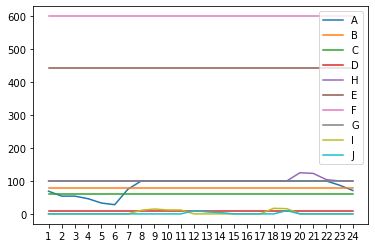

In [ ]:
for gen_name, gen_row in result_df.iterrows():
    plt.plot(gen_row.keys(), gen_row.values, label=gen_name)
plt.legend();

We can also try to understand this variation using a heatmap.

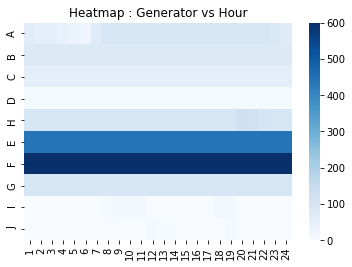

In [ ]:
gen_heatmap = sns.heatmap(result_df, cmap='Blues')
plt.title("Heatmap : Generator vs Hour")
plt.show()

### Lets look at the power generated by different generators in the optimal case:
#### Hydro generators:
For generators B, C and D, we can see that the output is constant irrespective of time. For A, it goes down from 10PM till 7AM and then comes back to 100 MW (from 7AM), which correlates to lower demand during this period. 

#### Gas generators:
For generator H, the output stays around 100 MW with a spike after 7PM. This can again be explained by spike in demand during this time.

#### Solid generators:
Since solid generators need to have constant output regardless of time/hour, both F and G needs to be used with their maximum output, and E with 442 MW.

#### Solar generators:
Solar generators, I and J are only used for few hours, since they have high costs compared to hydro and solid generators, and due to availability issues.

In [ ]:
# From lecture slides

# Activity and slack
for i, val in enumerate(solver.ComputeConstraintActivities()): # From https://stackoverflow.com/questions/522563/accessing-the-index-in-for-loops
    print(f"Activity for hour {i + 1} is {val}, Slack is {demand_constraints[i].ub() - val}")

Activity for hour 1 is 1461.0, Slack is 0.0
Activity for hour 2 is 1446.0, Slack is 0.0
Activity for hour 3 is 1446.0, Slack is 0.0
Activity for hour 4 is 1438.0, Slack is 0.0
Activity for hour 5 is 1425.0, Slack is 0.0
Activity for hour 6 is 1420.0, Slack is 0.0
Activity for hour 7 is 1467.0, Slack is 0.0
Activity for hour 8 is 1503.0, Slack is 0.0
Activity for hour 9 is 1507.0, Slack is 0.0
Activity for hour 10 is 1504.0, Slack is 0.0
Activity for hour 11 is 1504.0, Slack is 0.0
Activity for hour 12 is 1502.0, Slack is 0.0
Activity for hour 13 is 1498.0, Slack is 0.0
Activity for hour 14 is 1496.0, Slack is 0.0
Activity for hour 15 is 1492.0, Slack is 0.0
Activity for hour 16 is 1492.0, Slack is 0.0
Activity for hour 17 is 1492.0, Slack is 0.0
Activity for hour 18 is 1509.0, Slack is 0.0
Activity for hour 19 is 1518.0, Slack is 0.0
Activity for hour 20 is 1517.0, Slack is 0.0
Activity for hour 21 is 1515.0, Slack is 0.0
Activity for hour 22 is 1496.0, Slack is 0.0
Activity for hour 2

As expected, activity values for all the hours are equal to the demand we set previously. Slack is 0 for all hours as all our demand constraints are binding. 

The hourly dual values are as follows.

In [ ]:
for i in range(hours):
    print(f"Dual value for hour {i+1} is {demand_constraints[i].DualValue():.3f}")

Dual value for hour 1 is 1.400
Dual value for hour 2 is 1.400
Dual value for hour 3 is 1.400
Dual value for hour 4 is 1.400
Dual value for hour 5 is 1.400
Dual value for hour 6 is 1.400
Dual value for hour 7 is 1.400
Dual value for hour 8 is 6.600
Dual value for hour 9 is 6.600
Dual value for hour 10 is 6.600
Dual value for hour 11 is 6.600
Dual value for hour 12 is 6.600
Dual value for hour 13 is 6.600
Dual value for hour 14 is 6.600
Dual value for hour 15 is 1.400
Dual value for hour 16 is 1.400
Dual value for hour 17 is 3.500
Dual value for hour 18 is 6.600
Dual value for hour 19 is 6.600
Dual value for hour 20 is 9.100
Dual value for hour 21 is 9.100
Dual value for hour 22 is 9.100
Dual value for hour 23 is 1.400
Dual value for hour 24 is 1.400
